In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 求解区域的范围
x_range = [0.0, np.pi]
y_range = [0.0, np.pi]

h = np.pi/90

#coordinate of each point
x = np.arange(x_range[0],x_range[1]+h,h)
y = np.arange(y_range[0], y_range[1]+h,h)

#num of grid
x_n_grid = len(x)
y_n_grid = len(y)

#Mark boundary point
area = np.full(shape=(x_n_grid, y_n_grid), fill_value=True)
area[1: -1, 1: -1] = np.full(shape=(x_n_grid-2, y_n_grid-2), fill_value=False)

print(area)

[[ True  True  True ...  True  True  True]
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 ...
 [ True False False ... False False  True]
 [ True False False ... False False  True]
 [ True  True  True ...  True  True  True]]


In [14]:
#Build index matrix
index_matrix = np.zeros((x_n_grid, y_n_grid), dtype=int)

#boundary point = -1, points to be sought = numbered in sequence
k = 0
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if area[i,j]:
            index_matrix[i, j] = -1
        else:
            index_matrix[i, j] = k
            k += 1
size = k          
print(index_matrix)

[[  -1   -1   -1 ...   -1   -1   -1]
 [  -1    0    1 ...   87   88   -1]
 [  -1   89   90 ...  176  177   -1]
 ...
 [  -1 7743 7744 ... 7830 7831   -1]
 [  -1 7832 7833 ... 7919 7920   -1]
 [  -1   -1   -1 ...   -1   -1   -1]]


In [15]:
#Boundary condition
def edge_value(x, y):
    if x == 0.0 or x == np.pi or y == 0.0:
        return 0.0
    if y == np.pi:
        return np.sin(x)
    
#Build a function value matrix
value_matrix = np.zeros(shape=(x_n_grid, y_n_grid))

for i in range(x_n_grid):
    for j in range(y_n_grid):
        if area[i, j]:
            value_matrix[i, j] = edge_value(x[i], y[j])
            
print(value_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.0348995 ]
 [0.         0.         0.         ... 0.         0.         0.06975647]
 ...
 [0.         0.         0.         ... 0.         0.         0.06975647]
 [0.         0.         0.         ... 0.         0.         0.0348995 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [16]:
# q(x,y)
def q(x, y):
    return 0.0

q_matrix = np.zeros((x_n_grid, y_n_grid))

for i in range(x_n_grid):
    for j in range(y_n_grid):
        if not area[i, j]:
            q_matrix[i, j] = q(x[i], y[j])

print(q_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
A = []
b = []

for i in range(x_n_grid):
    for j in range(y_n_grid):
        #points to be sought
        if not area[i, j]:
            # initialize Aij&bij
            Aij = np.zeros(size)
            bij = -0.25*h*h*q_matrix[i, j]
            #Aij = 1
            Aij[index_matrix[i, j]] = 1.0
            #if boundary bij = value/4
            #if to be sought Aij = -1/4
            if area[i-1, j]:
                bij += 0.25*value_matrix[i-1, j]
            else:
                Aij[index_matrix[i-1, j]] =-0.25
            if area[i+1, j]:
                bij += 0.25*value_matrix[i+1, j]
            else:
                Aij[index_matrix[i+1, j]] =-0.25
            if area[i, j-1]:
                bij += 0.25*value_matrix[i, j-1]
            else:
                Aij[index_matrix[i, j-1]] =-0.25
            if area[i, j+1]:
                bij += 0.25*value_matrix[i, j+1]
            else:
                Aij[index_matrix[i, j+1]] =-0.25
            
            A.append(Aij)
            b.append([bij])

A = np.array(A)
b = np.array(b)
print(np.shape(A))
print(np.shape(b))

(7921, 7921)
(7921, 1)


In [18]:
omega = 7/4

#X^{k+1} = S_w*X^{k}+f_w
#S_w = (I+wD^{-1}L)^{-1}[(1-w)I-wD^{-1}U]
#f_w = w(I+wD^{-1}L)

D_inv = np.linalg.inv(np.diag(np.diag(A))) #numpy.diag()函数是以一维数组的形式返回方阵的对角线（或非对角线）元素，或将一维数组转换成方阵（非对角线元素为0）。两种功能角色转变取决于输入的v。
U = np.triu(A, k=1)#上三角（不包括对角
I= np.diag(np.ones(size))
L = np.tril(A, k=-1)

tmp = np.linalg.inv(I+omega*D_inv.dot(L))
S_omega = tmp.dot((1-omega)*I-omega*D_inv.dot(U))
f_omega = omega*tmp.dot(D_inv.dot(b))

# Iteration initial value
X0 = np.zeros((size, 1))

X = S_omega.dot(X0) + f_omega

# iterations
k = 1

while np.max(abs(X-X0)) > 1e-6:
    X0 = X
    X = S_omega.dot(X0) + f_omega
    k += 1

print(k)

942


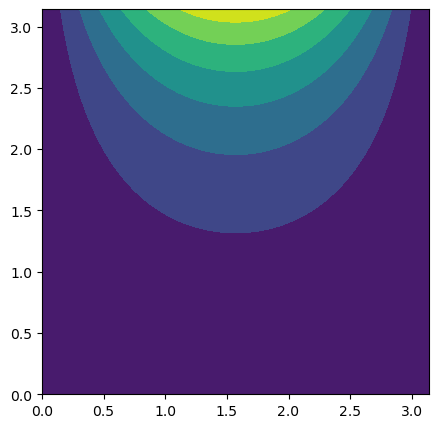

In [19]:
# picture
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if not area[i, j]:
            value_matrix[i, j] = X[index_matrix[i, j], 0]
            
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.contourf(x, y, value_matrix.T)
plt.show()

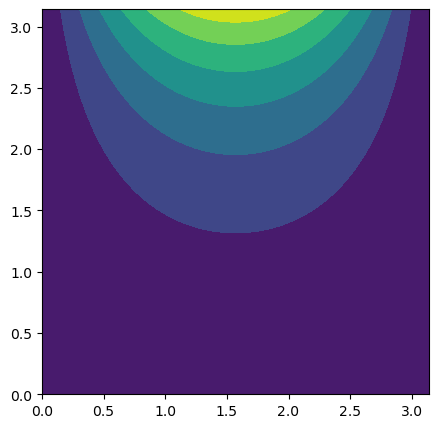

In [23]:
def exact(x,y):
    return np.sin(x)*np.sinh(y)/np.sinh(np.pi)

exact_matrix = np.zeros((x_n_grid, y_n_grid))
for i in range(x_n_grid):
    for j in range(y_n_grid):
            exact_matrix[i, j] = exact(x[i],y[j])
            
fig1 = plt.figure(figsize=(5, 5), dpi=100)
plt.contourf(x, y, exact_matrix.T)
plt.show()
            